<a href="https://colab.research.google.com/github/GreatLearningAIML1/delhi-may19-batch-Trapti04/blob/master/R9_Delhi_Internal_Lab_Questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Import the necessary libraries

In [0]:
import os
import pandas as pd
import patoolib
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

import tensorflow as tf

### Change directory

In [0]:

os.chdir('/content/drive/My Drive/R9_Delhi_Internal_Dataset')

### Load the training data from train.csv file

In [79]:
DATASET_FOLDER = '/content/drive/My Drive/R9_Delhi_Internal_Dataset/'
TRAIN_CSV = DATASET_FOLDER+"train_labels.csv"
rar_location = DATASET_FOLDER + "images_racoon.rar"
IMAGE_PATH = DATASET_FOLDER + "images"
train_df = pd.read_csv(TRAIN_CSV)
train_df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [80]:
train_df.shape

(173, 8)

In [81]:
! pip install patool

In [82]:
patoolib.extract_archive(rar_location)

patool: Extracting /content/drive/My Drive/R9_Delhi_Internal_Dataset/images_racoon.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/R9_Delhi_Internal_Dataset/images_racoon.rar"
patool:     with cwd='./Unpack_q84bu6uf'
patool: ... /content/drive/My Drive/R9_Delhi_Internal_Dataset/images_racoon.rar extracted to `images_racoon1' (local file exists).


'images_racoon1'

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

In [0]:
ALPHA = 1.0

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [95]:

with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    
    coords = np.zeros((sum(1 for line in csvfile) -1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader)
    for col, row in enumerate(reader):
              
        for i, r in enumerate(row[1:8]): # Parse row with eight entities
            row[i + 1] = r
              
        file_name, image_width, image_height,_, x0, y0, x1, y1 = row  
        path = IMAGE_PATH + "/" + file_name
        #print(file_name, image_width, image_height, x0, y0, x1, y1)
        coords[col, 0] = int(x0) * int( IMAGE_SIZE)/ int(image_width) # Normalize bounding box by image size
        coords[col, 1] = int(y0) * int(IMAGE_SIZE) / int(image_height) # Normalize bounding box by image size
        coords[col, 2] = (int(x1) - int(x0)) * int(IMAGE_SIZE )/ int(image_width )# Normalize bounding box by image size
        coords[col, 3] = (int(y1) - int(y0)) * int(IMAGE_SIZE) / int(image_height)
        paths.append(path)
        print(col)


        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172


### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

In [89]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [96]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve
gt = coords
model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)



Epoch 1/30
173/173 [==============================] - 7s 40ms/step - loss: 2858.2778 - IoU: 0.0851
Epoch 2/30
173/173 [==============================] - 5s 30ms/step - loss: 662.6192 - IoU: 0.4327
Epoch 3/30
173/173 [==============================] - 5s 30ms/step - loss: 645.4009 - IoU: 0.5391
Epoch 4/30
173/173 [==============================] - 5s 30ms/step - loss: 575.4185 - IoU: 0.5296
Epoch 5/30
173/173 [==============================] - 5s 30ms/step - loss: 335.2057 - IoU: 0.5905
Epoch 6/30
173/173 [==============================] - 5s 30ms/step - loss: 275.4648 - IoU: 0.5663
Epoch 7/30
173/173 [==============================] - 5s 31ms/step - loss: 256.0634 - IoU: 0.5960
Epoch 8/30
173/173 [==============================] - 5s 31ms/step - loss: 186.3604 - IoU: 0.6600
Epoch 9/30
173/173 [==============================] - 5s 31ms/step - loss: 156.6564 - IoU: 0.7090
Epoch 10/30
173/173 [==============================] - 5s 31ms/step - loss: 144.0377 - IoU: 0.7157
Epoch 11/30
173/

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename =  IMAGE_PATH + '/raccoon-6.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

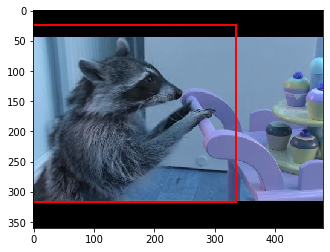

In [100]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [0]:
# done above

#### Change your present working directory

In [0]:
# working directory set above

### Load your data file

In [0]:
temp_df = pd.read_csv("daily-minimum-temperatures-in-me.csv")

#### Plot data

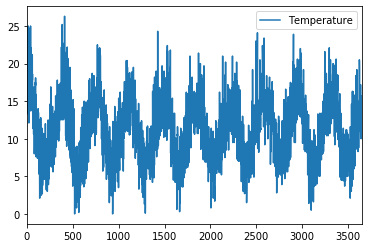

In [102]:
temp_df.plot()

#### Descibe your dataframe

In [103]:
temp_df.describe() # the data shows that there is seasonality, intercept and from 1000th day to 3000th day we also observe a trend of increases tempaertures thouht it is not very apparent

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [104]:
#Check for null values
temp_df.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

In [0]:
# no null values

#### Get the representation of the distribution of data in the form of histogram

In [0]:
import matplotlib.pyplot as plt


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61f1a3aac8>]],
      dtype=object)

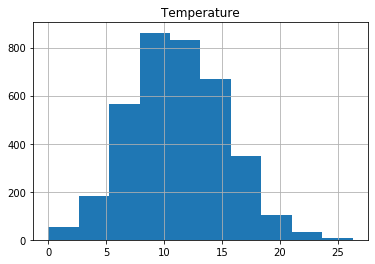

In [107]:
temp_df.hist()

#### Check the maximum and minimum values

In [109]:
print('Min', np.min(temp_df))
print('Max', np.max(temp_df))

Min Date           1981-01-01
Temperature             0
dtype: object
Max Date           1990-12-31
Temperature          26.3
dtype: object


### Normalize the data

In [0]:
temp_df.drop("Date", axis=1, inplace=True)

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
#Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(temp_df)

#### Check the maximum and minimum values of scaled data

In [118]:
print('Min', np.min(temp_df))
print('Max', np.max(temp_df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


#### Look into some of the scaled values

In [122]:
print('Sample s', temp_df.head(10))

Sample s    Temperature
0         20.7
1         17.9
2         18.8
3         14.6
4         15.8
5         15.8
6         15.8
7         17.4
8         21.8
9         20.0


### Split data into Training and Testing

In [0]:
#70% examples will used for training (in the begining)
train_size = int(len(scaled) * 0.70)

#30% will be used for Test
test_size = len(scaled - train_size)

In [0]:
#Split the data
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]


#### Print train and test size

In [125]:
print("Train size",train_size)
print("Test size",test_size)

Train size 2555
Test size 3650


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
#window - how long the sequence will be, default is sequence of 1
def create_dataset(dataset, window=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):
        
        a = dataset[i:(i+window), 0]        
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
#Create Input and Output
window_size = 1
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [0]:
# The LSTM network expects the input data (X) to be provided with a 
# specific array structure in the form of: [samples, time steps, features].

In [129]:
#Make it 3 Dimensional Data - needed for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2554, 1, 1)
(1094, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [130]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=(window_size, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Summarize your model

In [131]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [132]:
model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2554 samples, validate on 1094 samples
Epoch 1/200
2554/2554 [==============================] - 1s 433us/sample - loss: 0.0922 - val_loss: 0.0299
Epoch 2/200
2554/2554 [==============================] - 0s 121us/sample - loss: 0.0161 - val_loss: 0.0126
Epoch 3/200
2554/2554 [==============================] - 0s 129us/sample - loss: 0.0134 - val_loss: 0.0120
Epoch 4/200
2554/2554 [==============================] - 0s 123us/sample - loss: 0.0127 - val_loss: 0.0113
Epoch 5/200
2554/2554 [==============================] - 0s 117us/sample - loss: 0.0121 - val_loss: 0.0106
Epoch 6/200
2554/2554 [==============================] - 0s 129us/sample - loss: 0.0115 - val_loss: 0.0100
Epoch 7/200
2554/2554 [==============================] - 0s 121us/sample - loss: 0.0110 - val_loss: 0.0095
Epoch 8/200
2554/2554 [==============================] - 0s 123us/sample - loss: 0.0107 - val_loss: 0.0094
Ep

## Make Predictions and Evaluate your model

In [0]:
#Get prediction for both Training and Test Data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [0]:
#Un-normalize the predited data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

## Plot the results

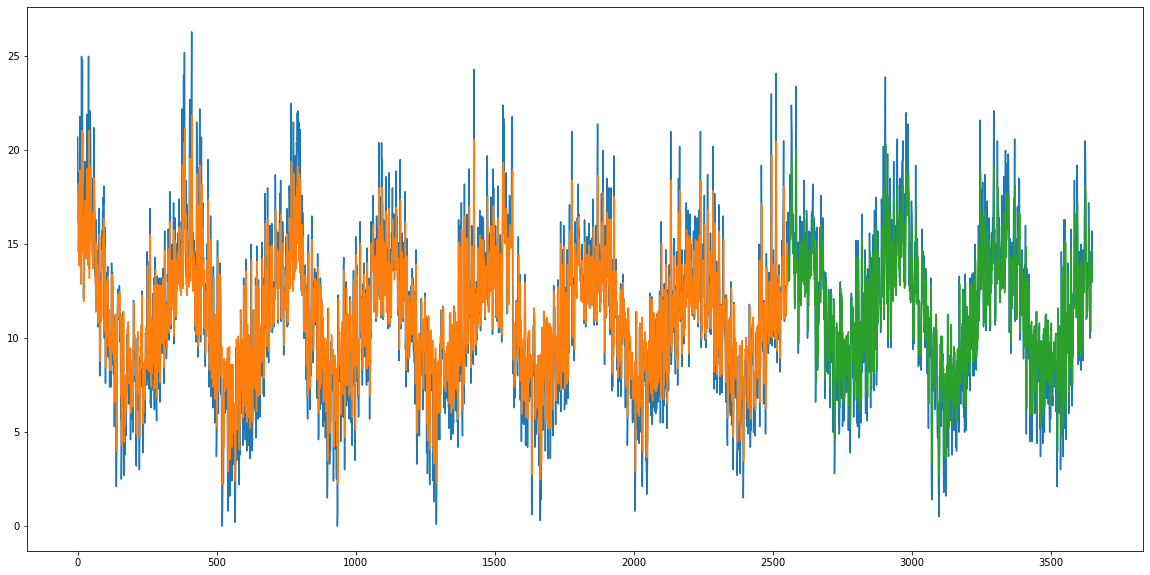

In [138]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [139]:
myInput = np.reshape(scaler.transform(pd.DataFrame({"Temperature":[21.8]})), 1,1)
int(scaler.inverse_transform(model.predict(np.reshape(myInput, (1, 1, 1)))))

18